XR version

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
import datetime
import sys
#import bottleneck


## Make test data section

In [72]:
var_file = '/export/gleckler1/processing/metrics_package/my_test/mfw_extremes/cmip6.historical.GFDL-CM4.r1i1p1f1.mon.pr_smalldomain.nc'
fx = xr.open_dataset(var_file)

In [ ]:
# Make some fake datasets to work out algorithm/speed

# Really low resolution

# Copying example from https://docs.xarray.dev/en/stable/examples/weather-data.html
#times = pd.date_range("1900-01-01", "1999-12-31", name="time")
times = xr.cftime_range(start="1980-01-01", end="1999-12-31", freq="D", calendar="noleap", name="time")
np.random.seed(123)
#darray = np.zeros((36500,5,4))
#annual_cycle = np.sin(2 * np.pi * (times.dayofyear / 365.25 - 0.28))
#base = 1 * annual_cycle.reshape(-1, 1)
#values = darray + base + 1 * np.random.randn(annual_cycle.size,5,4)
values = np.random.randn(len(times),5,4)
fake_xr_lowres = xr.Dataset({'pr': xr.DataArray(
                    data   = values,   # enter data here
                    dims   = ['time',"lat","lon"],
                    coords = {'time': times, "lat": fx.lat, "lon": fx.lon},
                    attrs  = {
                        '_FillValue': -999.9,
                        'units'     : ''
                        }
                    )})
#fake_xr_lowres['time'] = fake_xr_lowres.time.assign_attrs(encoding={'calendar': "noleap"})
#fake_xr = fake_xr.bounds.add_missing_bounds()
#fake_xr_lowres['pr'].time.encoding = {'calendar': "noleap"} 
#fake_xr_lowres.to_netcdf("test_data/lowres_modelA_1980-1999.nc")

times = xr.cftime_range(start="1970-01-01", end="1999-12-31", freq="D", calendar="proleptic_gregorian", name="time")
np.random.seed(456)
#darray = np.zeros((36500,5,4))
#annual_cycle = np.sin(2 * np.pi * (times.dayofyear / 365.25 - 0.28))
#base = 1 * annual_cycle.reshape(-1, 1)
#values = darray + base + 1 * np.random.randn(annual_cycle.size,5,4)
values = np.random.randn(len(times),5,4)
fake_xr_lowres = xr.Dataset({'pr': xr.DataArray(
                    data   = values,   # enter data here
                    dims   = ['time',"lat","lon"],
                    coords = {'time': times, "lat": fx.lat, "lon": fx.lon},
                    attrs  = {
                        '_FillValue': -999.9,
                        'units'     : ''
                        }
                    )})
#fake_xr_lowres['time'] = fake_xr_lowres.time.assign_attrs(encoding={'calendar': "proleptic_gregorian"})
#fake_xr = fake_xr.bounds.add_missing_bounds()
#fake_xr_lowres['pr'].time.encoding = {'calendar': "proleptic_gregorian"} 
#fake_xr_lowres.to_netcdf("test_data/lowres_modelB_1970-1999.nc")

# Medium resolution (would be lowres in model)
times = xr.cftime_range(start="1980-01-01", end="1999-12-31", freq="D", calendar="noleap", name="time")
lon = np.arange(0,360,2)
lat = np.arange(-90,90,2)
values = np.random.randn(len(times),len(lat),len(lon))
fake_xr_medres = xr.Dataset({'pr': xr.DataArray(
                    data   = values,   # enter data here
                    dims   = ['time',"lat","lon"],
                    coords = {'time': times, "lat": lat, "lon": lon},
                    attrs  = {
                        '_FillValue': -999.9,
                        'units'     : ''
                        }
                    )})
#fake_xr_medres['time'] = fake_xr_medres.time.assign_attrs(encoding={'calendar': "noleap"})
#fake_xr = fake_xr.bounds.add_missing_bounds()
#fake_xr_medres['pr'].time.encoding = {'calendar': "noleap"}   
#fake_xr_medres.to_netcdf("test_data/medres_modelC_1980-1999.nc")

# High resolution
times = xr.cftime_range(start="1995-01-01", end="1999-12-31", freq="D", calendar="noleap", name="time")
lon = np.arange(0,360,0.25)
lat = np.arange(-90,90,0.25)
values = np.random.randn(len(times),len(lat),len(lon))
fake_xr_hires = xr.Dataset({'pr': xr.DataArray(
                    data   = values,   # enter data here
                    dims   = ['time',"lat","lon"],
                    coords = {'time': times, "lat": lat, "lon": lon},
                    attrs  = {
                        '_FillValue': -999.9,
                        'units'     : ''
                        }
                    )})
#fake_xr_hires['time'] = fake_xr_hires.time.assign_attrs(encoding={'calendar': "noleap"})
#fake_xr = fake_xr.bounds.add_missing_bounds()
#fake_xr_hires['pr'].time.encoding = {'calendar': "noleap"}   
fake_xr_hires.to_netcdf("test_data/hires_modelC_1995-1999.nc")

In [192]:
# Other custom lowrest test sets I've tried:

times = xr.cftime_range(start="1980-01-01", end="1999-12-31", freq="D", calendar="proleptic_gregorian", name="time")
#values = np.ones((len(times),5,4)) * 5 # allfives
#values = np.random.randint(0, high=6, size=(len(times),5,4)) # randint
#values = np.ones((len(times),5,4)); values[:,0:2,] = 2.2 # splitgrid
values = np.ones((len(times),5,4)) * np.arange(1,len(times)+1).reshape(len(times),1,1) # inctime
fake_xr_lowres = xr.Dataset({'pr': xr.DataArray(
                    data   = values,   # enter data here
                    dims   = ['time',"lat","lon"],
                    coords = {'time': times, "lat": fx.lat, "lon": fx.lon},
                    attrs  = {
                        '_FillValue': -999.9,
                        'units'     : ''
                        }
                    )})
fake_xr_lowres.to_netcdf("test_data/lowres_inctime_gr_1980-1999.nc")

## Run algorithm

In [12]:
# parser args
dataset = "test_data/lowres_randint_1980-1999.nc"
drop_incomplete_djf = False
dec_mode = "DJF"
exclude_leap = False
annual_strict = True

In [13]:
%%time
ds = xr.open_dataset(dataset)

year_beg = ds.isel({"time": 0}).time.dt.year.item()
year_end = ds.isel({"time": -1}).time.dt.year.item()

if year_end < year_beg + 1:
    print("Error: Final year must be greater than beginning year.")
    sys.exit(1)

year_range = np.arange(year_beg,year_end+1,1)

cal = ds.time.encoding["calendar"]

if cal != "noleap" and exclude_leap:
    ds = ds.convert_calendar('noleap')
    cal = "noleap"
    
# Rename possible precipitation variable names for consistency
for variable in ["precip", "PRECT"]:
    if variable in ds:
        ds = ds.rename({variable: "pr"})

CPU times: user 2.47 ms, sys: 0 ns, total: 2.47 ms
Wall time: 2.32 ms


In [ ]:
# Do we want method to convert daily precip rate to daily total precipitation?

In [17]:
%%time

# Fill NaN's with 0 - can do with mask instead / keep nans
#ds.fillna(0)

# Fill negative numbers with 0
ds = ds.where(ds.pr >= 0, ds.pr, 0)

# Here is the rolling mean
fx_rolling =ds.pr.rolling(time=5).mean()

del_one_d = datetime.timedelta(days=1)
del_zero_d = datetime.timedelta(days=0)

# Annual
if annual_strict:
    # Only use data from that year - start on Jan 5 avg
    date_range = [xr.cftime_range(start=cftime.datetime(year,5,1,calendar=cal)-del_zero_d,
                              end = cftime.datetime(year+1,1,1,calendar=cal)-del_one_d,
                              freq='D',
                              calendar=cal) for year in year_range]
    fx_ann_max = fx.rolling.sel(time=date_range).groupby("time.year").max(dim="time")
else:
    # Mean can include rolling data from past year
    fx_ann_max = fx_rolling.groupby("time.year").max(dim="time")
    fx_ann_max = fx_ann_max.rename({"year": "time"})

# DJF
if dec_mode =="DJF":
    fx_DJF_max = fx_rolling.resample(time='QS-DEC').max(dim="time")
    fx_DJF_max = fx_DJF_max.isel(time=fx_DJF_max.time.dt.month.isin([12])) # djf will be in month "12" after resample
    if drop_incomplete_djf:
        fx_DJF_max = fx_DJF_max.sel(time=slice(str(year_beg),str(year_end-1)))
        fx_DJF_max["time"] = np.arange(year_beg+1,year_end+1)
    else:
        fx_DJF_max = fx_DJF_max.sel(time=slice(str(year_beg-1),str(year_end)))
        fx_DJF_max["time"] = np.arange(year_beg,year_end+2)
elif dec_mode == "JFD":
    date_range_1 = [xr.cftime_range(start=cftime.datetime(year,1,1,calendar=cal)-del_zero_d,
                        end=cftime.datetime(year,3,1,calendar=cal)-del_one_d,
                        freq='D',
                        calendar=cal) for year in year_range]
    date_range_1 = [item for sublist in date_range_1 for item in sublist]
    date_range_2 = [xr.cftime_range(start=cftime.datetime(year,12,1,calendar=cal)-del_zero_d,
                        end=cftime.datetime(year+1,1,1,calendar=cal)-del_one_d,
                        freq='D',
                        calendar=cal) for year in year_range]
    date_range_2 = [item for sublist in date_range_2 for item in sublist]
    date_range = sorted(date_range_1 + date_range_2)
    fx_DJF_max = fx_rolling.sel(time=date_range).groupby("time.year").max(dim="time")
    fx_DJF_max = fx_DJF_max.rename({"year": "time"})


# MAM
date_range = [xr.cftime_range(start=cftime.datetime(year,3,1,calendar=cal)-del_zero_d,
                              end=cftime.datetime(year,6,1,calendar=cal)-del_one_d,
                              freq='D',
                              calendar=cal) for year in year_range]
date_range = [item for sublist in date_range for item in sublist]
fx_MAM_max = fx_rolling.sel(time=date_range).groupby("time.year").max(dim="time")
fx_MAM_max = fx_MAM_max.rename({"year": "time"})


# JJA
date_range = [xr.cftime_range(start=cftime.datetime(year,6,1,calendar=cal)-del_zero_d,
                              end = cftime.datetime(year,9,1,calendar=cal)-del_one_d,
                              freq='D',
                              calendar=cal) for year in year_range]
date_range = [item for sublist in date_range for item in sublist]
fx_JJA_max = fx_rolling.sel(time=date_range).groupby("time.year").max(dim="time")
fx_JJA_max = fx_JJA_max.rename({"year": "time"})

# SON
date_range = [xr.cftime_range(start=cftime.datetime(year,9,1,calendar=cal)-del_zero_d,
                              end=cftime.datetime(year,12,1,calendar=cal)-del_one_d,
                              freq='D',
                              calendar=cal) for year in year_range]
date_range = [item for sublist in date_range for item in sublist]
fx_SON_max = fx_rolling.sel(time=date_range).groupby("time.year").max(dim="time")
fx_SON_max = fx_SON_max.rename({"year": "time"})


CPU times: user 104 ms, sys: 6.19 ms, total: 110 ms
Wall time: 111 ms


In [53]:
def get_seasonal_max(ds,season,dec_mode="DJF",drop_incomplete_djf=True):
    cal = ds.time.encoding["calendar"]

    year_beg = ds.isel({"time": 0}).time.dt.year.item()
    year_end = ds.isel({"time": -1}).time.dt.year.item()

    if year_end < year_beg + 1:
        print("Error: Final year must be greater than beginning year.")
        sys.exit(1)

    year_range = np.arange(year_beg,year_end+1,1)

    del_one_d = datetime.timedelta(days=1)
    del_zero_d = datetime.timedelta(days=0)

    dates = {"MAM": [(3,1), (6,1)], "JJA": [(6,1), (9,1)], "SON": [(9,1), (12,1)]}

    if season == "DJF" and dec_mode =="DJF":
        ds_max = ds.resample(time='QS-DEC').max(dim="time")
        ds_max = ds_max.isel(time=ds_max.time.dt.month.isin([12])) # djf will be in month "12" after resample
        if drop_incomplete_djf:
            ds_max = ds_max.sel(time=slice(str(year_beg),str(year_end-1)))
            ds_max["time"] = np.arange(year_beg+1,year_end+1)
        else:
            ds_max = ds_max.sel(time=slice(str(year_beg-1),str(year_end)))
            ds_max["time"] = np.arange(year_beg,year_end+2)
    elif season == "DJF" and dec_mode == "JFD":
        date_range_1 = [xr.cftime_range(start=cftime.datetime(year,1,1,calendar=cal)-del_zero_d,
                        end=cftime.datetime(year,3,1,calendar=cal)-del_one_d,
                        freq='D',
                        calendar=cal) for year in year_range]
        date_range_1 = [item for sublist in date_range_1 for item in sublist]
        date_range_2 = [xr.cftime_range(start=cftime.datetime(year,12,1,calendar=cal)-del_zero_d,
                        end=cftime.datetime(year+1,1,1,calendar=cal)-del_one_d,
                        freq='D',
                        calendar=cal) for year in year_range]
        date_range_2 = [item for sublist in date_range_2 for item in sublist]
        date_range = sorted(date_range_1 + date_range_2)
        ds_max = ds.sel(time=date_range).groupby("time.year").max(dim="time")
        ds_max = ds_max.rename({"year": "time"})
    else:
        mo_st = dates[season][0][0]
        day_st = dates[season][0][1]
        mo_en = dates[season][1][0]
        day_en = dates[season][1][1]
        date_range = [xr.cftime_range(start=cftime.datetime(year,mo_st,day_st,calendar=cal)-del_zero_d,
                              end=cftime.datetime(year,mo_en,day_en,calendar=cal)-del_one_d,
                              freq='D',
                              calendar=cal) for year in year_range]
        date_range = [item for sublist in date_range for item in sublist]
        ds_max = ds.sel(time=date_range).groupby("time.year").max(dim="time")
        ds_max = ds_max.rename({"year": "time"})  
    print(ds_max)
    
get_seasonal_max(fx_rolling,"DJF")

<xarray.DataArray 'pr' (time: 19, lat: 5, lon: 4)>
array([[[3.8, 4. , 4.6, 3.8],
        [4. , 4.6, 4.4, 4.2],
        [4.4, 4. , 3.8, 4.2],
        [4.2, 4. , 4. , 4.6],
        [4. , 4.4, 4.4, 4. ]],

       [[3.8, 4.6, 4.6, 4.2],
        [5. , 3.8, 4.2, 4.2],
        [4. , 3.4, 4. , 4.4],
        [4. , 4.2, 4.8, 3.8],
        [4.4, 4.2, 4.2, 5. ]],

       [[4.2, 3.8, 4. , 4. ],
        [4.2, 4. , 4.2, 4. ],
        [3.8, 4.2, 4. , 4. ],
        [4. , 4.2, 4.2, 4. ],
        [4. , 4.6, 4.2, 3.8]],

       [[4. , 4.2, 3.8, 3.8],
        [4.2, 4.2, 4.4, 4. ],
...
        [4.4, 4.6, 4.2, 4.2],
        [4.2, 4. , 4. , 4.6]],

       [[4. , 4.6, 4.2, 4.6],
        [4. , 4.4, 4.4, 4.2],
        [4. , 4.8, 3.8, 3.8],
        [3.8, 4. , 4.6, 4.2],
        [4.6, 4. , 4. , 4.4]],

       [[4. , 3.8, 4.8, 4.2],
        [4.2, 4. , 4. , 4.2],
        [4.4, 3.6, 4.6, 3.8],
        [4.2, 4.6, 3.8, 3.8],
        [4.6, 4. , 3.8, 4. ]],

       [[4.2, 4.6, 4.2, 3.8],
        [4.4, 4. , 3.8, 4.4],
   

# Compare outputs

allfives: no differences  
randint: random differences at single grid cells  
splitgrid: no differences  
inctime: annual has no difference, seasonal off by 1.0
inctime_360: annual has no differece, JJA off by 2, SON off by 1, DJF off by -1, MAM off by 2 

In [302]:
f_original = "historical/pr_max_pentad_randint.nc"
ds_original = xr.open_dataset(f_original,use_cftime=True,decode_times=False)
ds_original['time'] = ds_original.time.assign_attrs(encoding={'calendar': cal})

In [303]:
ds_original.pr_annual_daily_max
ds_original.pr_annual_daily_max.isel({"time":0})
ds_rename = ds_original.rename({"latitude":"lat","longitude":"lon"})

In [304]:
print(fx_ann_max.isel({"time": 0}).time.item())
print(ds_rename.isel({"time": 0}).time.item())

1981
1981.0


In [305]:
yr1 = int(ds_rename.time[0].item())
yr2 = int(ds_rename.time[-1].item())

In [306]:
for n in range(yr1,yr2+1):
    tmp_result = ds_rename.pr_annual_daily_max.sel({"time":n}).drop("time") - fx_ann_max.sel({"time":n}).drop("time")
    print(n, tmp_result.max().item(), tmp_result.min().item(), tmp_result.mean().item())

1981 0.0 0.0 0.0
1982 0.0 0.0 0.0
1983 0.0 0.0 0.0
1984 0.0 0.0 0.0
1985 0.0 0.0 0.0
1986 0.0 0.0 0.0
1987 0.0 0.0 0.0
1988 0.0 0.0 0.0
1989 0.0 0.0 0.0
1990 0.0 0.0 0.0
1991 0.0 0.0 0.0
1992 0.0 0.0 0.0
1993 0.0 0.0 0.0
1994 0.0 0.0 0.0
1995 0.0 0.0 0.0
1996 0.0 0.0 0.0
1997 0.0 0.0 0.0
1998 0.0 0.0 0.0
1999 0.0 0.0 0.0


JJA

In [307]:
for n in range(yr1,yr2+1):
    tmp_result = ds_rename.pr_JJA_daily_max.sel({"time":n}).drop("time") - fx_JJA_max.sel({"time":n}).drop("time")
    print(n, tmp_result.max().item(), tmp_result.min().item(), tmp_result.mean().item())


1981 0.0 0.0 0.0
1982 0.0 0.0 0.0
1983 0.0 0.0 0.0
1984 0.0 0.0 0.0
1985 0.0 0.0 0.0
1986 0.0 0.0 0.0
1987 0.0 0.0 0.0
1988 0.0 0.0 0.0
1989 0.0 0.0 0.0
1990 0.0 0.0 0.0
1991 0.0 0.0 0.0
1992 0.0 0.0 0.0
1993 0.0 0.0 0.0
1994 0.0 0.0 0.0
1995 0.0 0.0 0.0
1996 0.0 0.0 0.0
1997 0.0 0.0 0.0
1998 0.0 0.0 0.0
1999 0.0 0.0 0.0


SON

In [308]:
for n in range(yr1,yr2+1):
    tmp_result = ds_rename.pr_SON_daily_max.sel({"time":n}).drop("time") - fx_SON_max.sel({"time":n}).drop("time")
    print(n, tmp_result.max().item(), tmp_result.min().item(), tmp_result.mean().item())


1981 0.0 0.0 0.0
1982 0.0 0.0 0.0
1983 0.0 0.0 0.0
1984 0.0 0.0 0.0
1985 0.0 0.0 0.0
1986 0.0 0.0 0.0
1987 0.0 0.0 0.0
1988 0.0 -0.8000000000000003 -0.040000000000000015
1989 0.0 0.0 0.0
1990 0.0 0.0 0.0
1991 0.0 -0.40000000000000036 -0.030000000000000027
1992 0.0 -0.20000000000000018 -0.010000000000000009
1993 0.0 0.0 0.0
1994 0.0 0.0 0.0
1995 0.0 -0.20000000000000018 -0.010000000000000009
1996 0.0 0.0 0.0
1997 0.0 -0.3999999999999999 -0.019999999999999997
1998 0.0 -0.40000000000000036 -0.020000000000000018
1999 0.0 0.0 0.0


DJF  
Here I'm expecting some differences because of dates

In [309]:
for n in range(yr1,yr2+1):
    tmp_result = ds_rename.pr_DJF_daily_max.sel({"time":n}).drop("time") - fx_DJF_max.sel({"time":n}).drop("time")
    print(n, tmp_result.max().item(), tmp_result.min().item(), tmp_result.mean().item())


1981 0.0 0.0 0.0
1982 0.0 0.0 0.0
1983 0.0 0.0 0.0
1984 0.0 0.0 0.0
1985 0.0 0.0 0.0
1986 0.0 0.0 0.0
1987 0.0 0.0 0.0
1988 0.0 0.0 0.0
1989 0.0 0.0 0.0
1990 0.0 0.0 0.0
1991 0.0 0.0 0.0
1992 0.0 0.0 0.0
1993 0.0 0.0 0.0
1994 0.0 0.0 0.0
1995 0.0 0.0 0.0
1996 0.0 0.0 0.0
1997 0.0 0.0 0.0
1998 0.0 0.0 0.0
1999 0.0 0.0 0.0


MAM  
Here I'm also expecting some differences - but it appears not

In [310]:
for n in range(yr1,yr2+1):
    tmp_result = ds_rename.pr_MAM_daily_max.sel({"time":n}).drop("time") - fx_MAM_max.sel({"time":n}).drop("time")
    print(n, tmp_result.max().item(), tmp_result.min().item(), tmp_result.mean().item())


1981 0.0 0.0 0.0
1982 0.0 0.0 0.0
1983 0.0 0.0 0.0
1984 0.0 0.0 0.0
1985 0.0 0.0 0.0
1986 0.0 0.0 0.0
1987 0.0 0.0 0.0
1988 0.0 0.0 0.0
1989 0.0 0.0 0.0
1990 0.0 0.0 0.0
1991 0.0 0.0 0.0
1992 0.0 0.0 0.0
1993 0.0 0.0 0.0
1994 0.0 0.0 0.0
1995 0.0 0.0 0.0
1996 0.0 0.0 0.0
1997 0.0 0.0 0.0
1998 0.0 0.0 0.0
1999 0.0 0.0 0.0


#### DJF Deep dive for randint dataset

In [284]:
problem_year = 1981

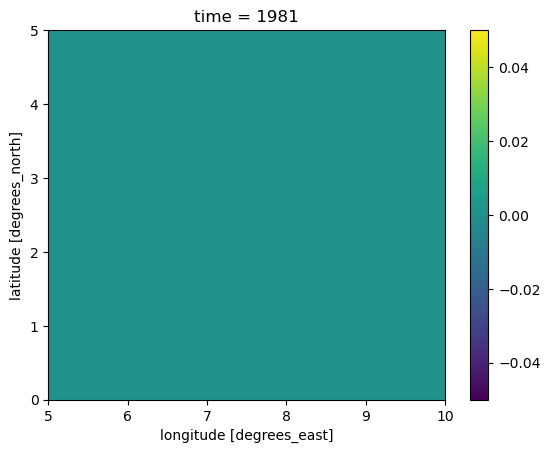

In [285]:
(fx_DJF_max.sel({"time":problem_year})- ds_rename.pr_DJF_daily_max.sel({"time":problem_year})).plot()

In [286]:
fx_DJF_max.sel({"time":problem_year}).values

array([[3.8, 4. , 4.6, 3.8],
       [4. , 4.6, 4.4, 4.2],
       [4.4, 4. , 3.8, 4.2],
       [4.2, 4. , 4. , 4.6],
       [4. , 4.4, 4.4, 4. ]])

In [287]:
ds_rename.sel({"time":problem_year}).pr_DJF_daily_max.values

array([[3.8, 4. , 4.6, 3.8],
       [4. , 4.6, 4.4, 4.2],
       [4.4, 4. , 3.8, 4.2],
       [4.2, 4. , 4. , 4.6],
       [4. , 4.4, 4.4, 4. ]])

I'll try to manually figure out what the right maximum at the difference grid cell should be.

In [288]:
difference = fx_DJF_max.sel({"time":problem_year}) - ds_rename.sel({"time":problem_year}).pr_DJF_daily_max

In [289]:
difference.sel({"lat": 2.5, "lon": 9.375})

<xarray.DataArray ()>
array(0.)
Coordinates:
    lat      float64 2.5
    lon      float64 9.375
    time     int64 1981

In [290]:
# Manually get rolling mean values, masking out just the cell with the difference. 
# Since there is just the one non-NaN cell, we can grab it by calling for the max value.
# Start in December from the prior year.
start_year = str(problem_year-1)+"-12-01"
end_year = str(problem_year)+"-02-28"
difference_cell_check = np.zeros((90,1))
for ind,day in enumerate(ds.sel(time=slice(start_year,end_year)).time): 
    difference_cell_check[ind] = 0.2 * (
        ds.sel({"time":day, "lat": 2.5, "lon": 9.375}).pr + 
        ds.sel({"time": day - datetime.timedelta(days=1), "lat": 2.5, "lon": 9.375}).pr +
        ds.sel({"time": day - datetime.timedelta(days=2), "lat": 2.5, "lon": 9.375}).pr +
        ds.sel({"time": day - datetime.timedelta(days=3), "lat": 2.5, "lon": 9.375}).pr +
        ds.sel({"time": day - datetime.timedelta(days=4), "lat": 2.5, "lon": 9.375}).pr)

In [291]:
difference_cell_check.max()
# This gives us the same value as xarray

4.2

In [292]:
difference_cell_check
# 4.2 is middle of the pack

array([[2. ],
       [1.8],
       [2.4],
       [2.6],
       [3.4],
       [3.2],
       [3.4],
       [2.8],
       [2.2],
       [2.4],
       [3. ],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.4],
       [2.8],
       [3. ],
       [2.6],
       [2.8],
       [2.6],
       [2.2],
       [2. ],
       [1.6],
       [1.6],
       [2.2],
       [2.4],
       [3.2],
       [3.2],
       [3. ],
       [2.8],
       [2.4],
       [2. ],
       [1.8],
       [1.4],
       [1.6],
       [2. ],
       [2. ],
       [2.2],
       [2.8],
       [2. ],
       [1.6],
       [1.8],
       [2.6],
       [2.6],
       [3.6],
       [4. ],
       [4.2],
       [3.8],
       [3. ],
       [2.6],
       [2.4],
       [1.6],
       [1.2],
       [2.2],
       [1.6],
       [1.8],
       [2.6],
       [3.4],
       [3. ],
       [3.8],
       [3.4],
       [3.4],
       [3.4],
       [2.8],
       [2.4],
       [3. ],
       [2.6],
       [1.6],
       [2.2],
      

In [293]:
np.sort(difference_cell_check,axis=0)

array([[1.2],
       [1.2],
       [1.4],
       [1.6],
       [1.6],
       [1.6],
       [1.6],
       [1.6],
       [1.6],
       [1.6],
       [1.6],
       [1.8],
       [1.8],
       [1.8],
       [1.8],
       [1.8],
       [1.8],
       [1.8],
       [1.8],
       [2. ],
       [2. ],
       [2. ],
       [2. ],
       [2. ],
       [2. ],
       [2. ],
       [2. ],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3.2],
      

Comparing the xarray rolling results for these months with a manual loop using numpy. They each produce the same results when the problem cell is not addressed in isolation.

In [294]:
fx_rolling.sel(time=slice(str(problem_year-1)+"-12-01",str(problem_year)+"-02-28")).max(dim="time")

<xarray.DataArray 'pr' (lat: 5, lon: 4)>
array([[3.8, 4. , 4.6, 3.8],
       [4. , 4.6, 4.4, 4.2],
       [4.4, 4. , 3.8, 4.2],
       [4.2, 4. , 4. , 4.6],
       [4. , 4.4, 4.4, 4. ]])
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) float64 5.625 6.875 8.125 9.375

In [295]:
manual = np.zeros((90,5,4))
for ind,day in enumerate(ds.sel(time=slice(str(problem_year-1)+"-12-01",str(problem_year)+"-02-28")).time): 
    manual[ind] = 0.2 * (ds.sel({"time":day}).pr + 
        ds.sel({"time": day - datetime.timedelta(days=1)}).pr +
        ds.sel({"time": day - datetime.timedelta(days=2)}).pr +
        ds.sel({"time": day - datetime.timedelta(days=3)}).pr +
        ds.sel({"time": day - datetime.timedelta(days=4)}).pr)

In [296]:
manual.max(axis=0)

array([[3.8, 4. , 4.6, 3.8],
       [4. , 4.6, 4.4, 4.2],
       [4.4, 4. , 3.8, 4.2],
       [4.2, 4. , 4. , 4.6],
       [4. , 4.4, 4.4, 4. ]])

Looking more at how we select the days

In [298]:
djf_from_roll = fx_rolling.resample(time='QS-DEC').max(dim="time")
print(djf_from_roll.sel({"time": str(problem_year-1)+"-12-01"}))
# This still matches the manual calculation

<xarray.DataArray 'pr' (time: 1, lat: 5, lon: 4)>
array([[[3.8, 4. , 4.6, 3.8],
        [4. , 4.6, 4.4, 4.2],
        [4.4, 4. , 3.8, 4.2],
        [4.2, 4. , 4. , 4.6],
        [4. , 4.4, 4.4, 4. ]]])
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) float64 5.625 6.875 8.125 9.375
  * time     (time) object 1980-12-01 00:00:00
Attributes:
    units:    


In [300]:
djf_from_roll = djf_from_roll.isel(time=djf_from_roll.time.dt.month.isin([12]))
print(djf_from_roll.sel({"time": str(problem_year-1)}))
# Still matches

<xarray.DataArray 'pr' (time: 1, lat: 5, lon: 4)>
array([[[3.8, 4. , 4.6, 3.8],
        [4. , 4.6, 4.4, 4.2],
        [4.4, 4. , 3.8, 4.2],
        [4.2, 4. , 4. , 4.6],
        [4. , 4.4, 4.4, 4. ]]])
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) float64 5.625 6.875 8.125 9.375
  * time     (time) object 1980-12-01 00:00:00
Attributes:
    units:    


In [301]:
djf_from_roll = djf_from_roll.sel(time=slice("{0}-01-01".format(year_beg),"{0}-12-31".format(year_end-1)))
print(djf_from_roll.sel({"time": str(problem_year-1)}))
# Still matches!

<xarray.DataArray 'pr' (time: 1, lat: 5, lon: 4)>
array([[[3.8, 4. , 4.6, 3.8],
        [4. , 4.6, 4.4, 4.2],
        [4.4, 4. , 3.8, 4.2],
        [4.2, 4. , 4. , 4.6],
        [4. , 4.4, 4.4, 4. ]]])
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) float64 5.625 6.875 8.125 9.375
  * time     (time) object 1980-12-01 00:00:00
Attributes:
    units:    


In [32]:
djf_from_roll["time"] = np.arange(year_beg+1,year_end+1)
djf_from_roll.time.attrs["units"] = "years since 0000-01-01"

In [33]:
djf_from_roll.sel({"time": problem_year})

<xarray.DataArray 'pr' (lat: 5, lon: 4)>
array([[3.8, 4. , 4.6, 3.8],
       [4. , 4.6, 4.4, 4.2],
       [4.4, 4. , 3.8, 4.2],
       [4.2, 4. , 4. , 4.6],
       [4. , 4.4, 4.4, 4. ]])
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) float64 5.625 6.875 8.125 9.375
    time     int64 1981
Attributes:
    units:

In [34]:
ds_rename.sel({"time":problem_year}).time

<xarray.DataArray 'time' ()>
array(1981.)
Coordinates:
    time     float64 1.981e+03
Attributes:
    units:    years since 00-01-01 00:00:00

#### JJA Deep Dive for randint dataset

In [36]:
problem_year = 1988

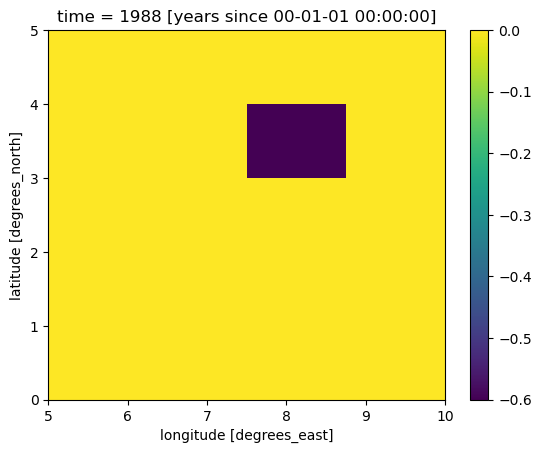

In [37]:
(fx_JJA_max.sel({"time":problem_year})- ds_rename.pr_JJA_daily_max.sel({"time":problem_year})).plot()

In [55]:
fx_JJA_max.sel({"time":problem_year}).values

array([[3.8, 4. , 4.2, 4.6],
       [4. , 4.2, 4.2, 3.8],
       [4. , 4. , 4.6, 4.6],
       [4. , 3.8, 3.8, 4. ],
       [4. , 4. , 3.6, 4.6]])

In [54]:
ds_rename.pr_JJA_daily_max.sel({"time":problem_year}).values

array([[3.8, 4. , 4.2, 4.6],
       [4. , 4.2, 4.2, 3.8],
       [4. , 4. , 4.6, 4.6],
       [4. , 3.8, 4.4, 4. ],
       [4. , 4. , 3.6, 4.6]])

In [68]:
cftime.datetime(1988,8,31) - cftime.datetime(1988,6,1)

datetime.timedelta(days=91)

In [38]:
difference = fx_JJA_max.sel({"time":problem_year}) - ds_rename.sel({"time":problem_year}).pr_JJA_daily_max

In [40]:
difference.sel({"lat": 3.5, "lon": 8.125})

<xarray.DataArray ()>
array(-0.6)
Coordinates:
    lat      float64 3.5
    lon      float64 8.125
    time     int64 1988

In [65]:
# Manually get rolling mean values, masking out just the cell with the difference. 
start_date = str(problem_year)+"-06-01"
end_date = str(problem_year)+"-08-31"
difference_cell_check = np.zeros((92,1))
for ind,day in enumerate(ds.sel(time=slice(start_date,end_date)).time): 
    #print(day)
    difference_cell_check[ind] = 0.2 * (
        ds.sel({"time":day, "lat": 2.5, "lon": 9.375}).pr + 
        ds.sel({"time": day - datetime.timedelta(days=1), "lat": 3.5, "lon": 8.125}).pr +
        ds.sel({"time": day - datetime.timedelta(days=2), "lat": 3.5, "lon": 8.125}).pr +
        ds.sel({"time": day - datetime.timedelta(days=3), "lat": 3.5, "lon": 8.125}).pr +
        ds.sel({"time": day - datetime.timedelta(days=4), "lat": 3.5, "lon": 8.125}).pr)

In [66]:
np.sort(difference_cell_check,axis=0)

array([[1.2],
       [1.2],
       [1.4],
       [1.6],
       [1.6],
       [1.6],
       [1.8],
       [1.8],
       [1.8],
       [1.8],
       [1.8],
       [1.8],
       [2. ],
       [2. ],
       [2. ],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.2],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.4],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.6],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [2.8],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
       [3. ],
      

In [275]:
import cdms2 as cdms
import cdtime

In [276]:
cdtime.comptime(1980, 1, 1).torel("days since 1980-01-01").value

0.0